## Get inside Working Directory

In [1]:
cd /content/drive/MyDrive

/content/drive/MyDrive


## Import necessary packages and enable GPU

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
# import torchsample as ts

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


## Initiate the train-test paths and encode labels for mapping

In [3]:
DIR_TRAIN = '/content/drive/MyDrive/gray_mal_dataset/train/'
DIR_TEST = '/content/drive/MyDrive/gray_mal_dataset/val/'

labels = os.listdir(DIR_TRAIN)
labels_val = os.listdir(DIR_TEST)
# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100'000 items)
files_train = []
labels_train = []
for label in labels:
    # print(label)
    for filename in os.listdir(DIR_TRAIN+label):
        # print(DIR_TRAIN+label+'/'+filename)
        files_train.append(DIR_TRAIN+label+'/'+filename)
        labels_train.append(label)
# print(files_train)
# Create lists of files and labels for validation (10'000 items)
files_val = []
labels_v = []
for val_label in labels_val:
  for val_filename in os.listdir(DIR_TEST+val_label):
      files_val.append(DIR_TEST + val_label+'/'+val_filename)
      labels_v.append(val_label)
print("The first five files from the list of train images:", files_train[:5])
print("\nThe first five labels from the list of train labels:", labels_train[:5])
print("\nThe first five files from the list of validation images:", files_val[:5])
print("\nThe first five labels from the list of validation labels:", labels_v[:5])

The first five files from the list of train images: ['/content/drive/MyDrive/gray_mal_dataset/train/2/322.png', '/content/drive/MyDrive/gray_mal_dataset/train/2/153.png', '/content/drive/MyDrive/gray_mal_dataset/train/2/29.png', '/content/drive/MyDrive/gray_mal_dataset/train/2/180.png', '/content/drive/MyDrive/gray_mal_dataset/train/2/366.png']

The first five labels from the list of train labels: ['2', '2', '2', '2', '2']

The first five files from the list of validation images: ['/content/drive/MyDrive/gray_mal_dataset/val/0/503.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/828.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2130.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2173.png', '/content/drive/MyDrive/gray_mal_dataset/val/0/2094.png']

The first five labels from the list of validation labels: ['0', '0', '0', '0', '0']


## Transform the dataset into Torch Vision format for training

In [4]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    # torchvision.transforms.RandomRotation((30,70)), # data augmentation: rotation 
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

## Create trainable data after augmentation

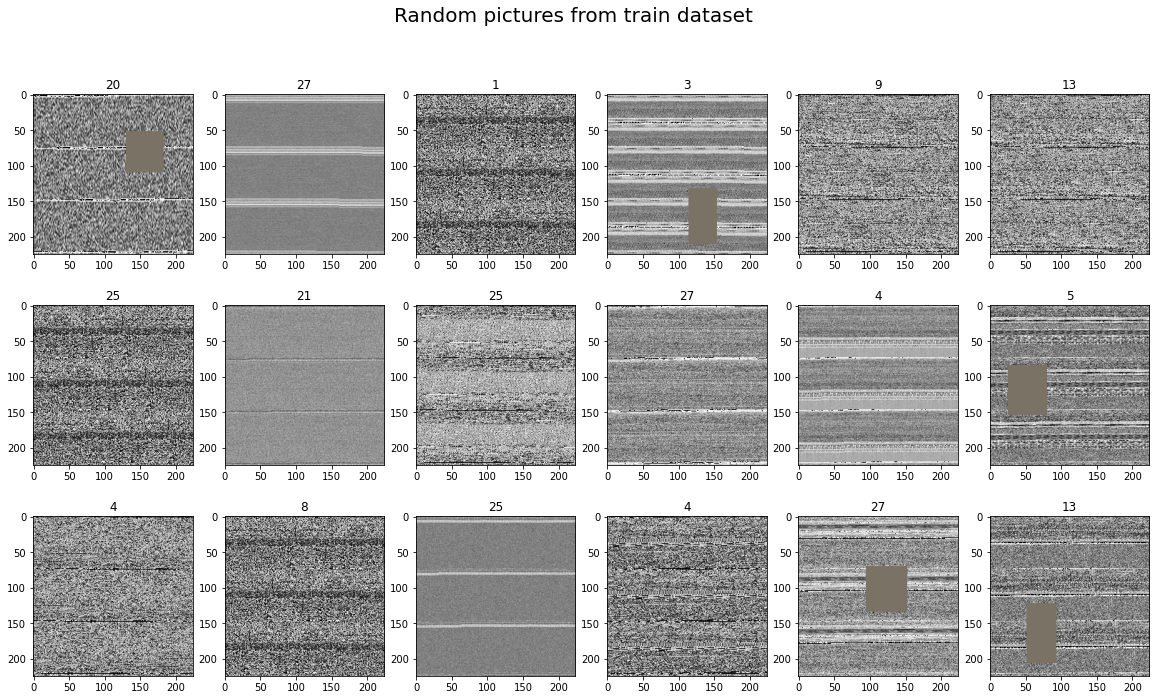

In [5]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_v,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')


fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Random pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

## Execute training function for all the models

In [6]:
def training(model, model_name, num_epochs, train_dataloader, val_dataloader):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.33)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None

    for epoch in tqdm(range(num_epochs)):

        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, scheduler.get_lr()))

        for phase in ['train', 'val']:

            epoch_loss = 0
            epoch_correct_items = 0
            epoch_items = 0

            if phase == 'train':
                model.train()
                with torch.enable_grad():
                    for samples, targets in train_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        optimizer.zero_grad()
                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()
                        
                        loss.backward()
                        optimizer.step()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                train_loss_array.append(epoch_loss / epoch_items)
                train_acc_array.append(epoch_correct_items / epoch_items)

                scheduler.step()

            elif phase == 'val':
                model.eval()
                with torch.no_grad():
                    for samples, targets in val_dataloader:
                        samples = samples.to(DEVICE)
                        targets = targets.to(DEVICE)

                        outputs = model(samples)
                        loss = loss_function(outputs, targets)
                        preds = outputs.argmax(dim=1)
                        correct_items = (preds == targets).float().sum()

                        epoch_loss += loss.item()
                        epoch_correct_items += correct_items.item()
                        epoch_items += len(targets)
                print(epoch_items)

                val_loss_array.append(epoch_loss / epoch_items)
                val_acc_array.append(epoch_correct_items / epoch_items)

                if epoch_loss / epoch_items < lowest_val_loss:
                    lowest_val_loss = epoch_loss / epoch_items
                    torch.save(model.state_dict(), '{}_weights.pth'.format(model_name))
                    best_model = copy.deepcopy(model)
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

## Execute graph plotting function for all the models

In [7]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

## Initiate train-test dataloaders and declare epochs for training the models

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 10

## DenseNet161 model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [04:31<40:41, 271.25s/it]

	| New lowest val loss for DenseNet161: 0.05137532341907176
Epoch: 2 | Learning rate: [0.0003]
2857


 20%|██        | 2/10 [05:07<17:41, 132.73s/it]

726
Epoch: 3 | Learning rate: [0.0003]
2857
726


 30%|███       | 3/10 [05:43<10:22, 88.86s/it] 

	| New lowest val loss for DenseNet161: 0.05100624324861637
Epoch: 4 | Learning rate: [3.267e-05]
2857
726


 40%|████      | 4/10 [06:21<06:53, 68.88s/it]

	| New lowest val loss for DenseNet161: 0.05094204231398822
Epoch: 5 | Learning rate: [9.9e-05]
2857
726


 50%|█████     | 5/10 [06:59<04:47, 57.55s/it]

	| New lowest val loss for DenseNet161: 0.05090136994343487
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [07:36<03:21, 50.50s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [08:13<02:18, 46.05s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [08:49<01:26, 43.11s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857
726


 90%|█████████ | 9/10 [09:27<00:41, 41.27s/it]

	| New lowest val loss for DenseNet161: 0.0508832701638382
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [10:03<00:00, 60.39s/it]

726


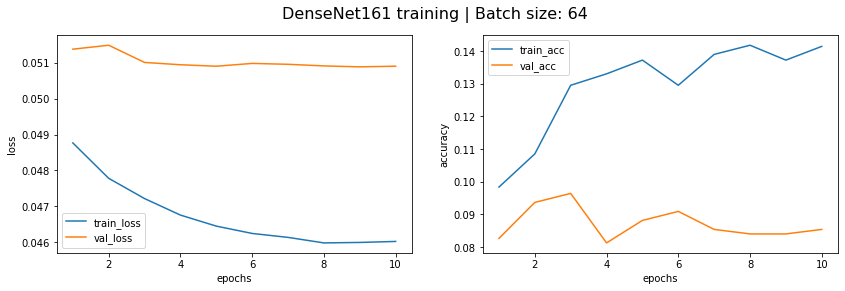


Training results:
	Min val loss 0.0509 was achieved during epoch #9
	Val accuracy during min val loss is 0.0840


In [9]:
model_densenet161 = models.densenet161(pretrained=True)
for param in model_densenet161.parameters():
    param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier.in_features, out_features=28)
model_densenet161 = model_densenet161.to(DEVICE)

densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="DenseNet161",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## Predictions of DenseNet161 model and savind the results in CSV file

In [10]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

model_densenet161.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        # print(f_names)
        samples = samples.to(DEVICE)
        outputs = model_densenet161(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)
# print(all_files)

all_filenames = [f_name for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('/content/drive/MyDrive/densenet_test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


,File,Prediction
0,tensor(0),20
1,tensor(0),21
2,tensor(0),4
3,tensor(0),4
4,tensor(0),27
5,tensor(0),20
6,tensor(0),27
7,tensor(0),4
8,tensor(0),21
9,tensor(0),4


## ResNet152 Model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [00:40<06:05, 40.59s/it]

	| New lowest val loss for ResNet152: 0.05119821946483013
Epoch: 2 | Learning rate: [0.0003]
2857
726


 20%|██        | 2/10 [01:20<05:19, 39.99s/it]

	| New lowest val loss for ResNet152: 0.050916961073547026
Epoch: 3 | Learning rate: [0.0003]
2857


 30%|███       | 3/10 [01:57<04:32, 38.88s/it]

726
Epoch: 4 | Learning rate: [3.267e-05]
2857


 40%|████      | 4/10 [02:35<03:50, 38.46s/it]

726
Epoch: 5 | Learning rate: [9.9e-05]
2857
726


 50%|█████     | 5/10 [03:13<03:12, 38.45s/it]

	| New lowest val loss for ResNet152: 0.05065392725395434
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [03:52<02:34, 38.55s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [04:30<01:54, 38.25s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [05:07<01:15, 38.00s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 90%|█████████ | 9/10 [05:45<00:37, 37.90s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [06:22<00:00, 38.29s/it]

726


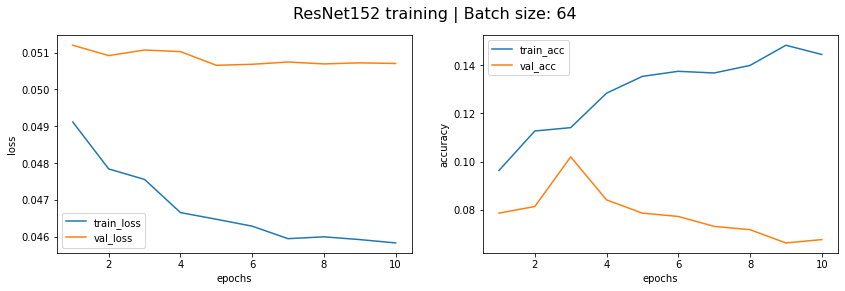


Training results:
	Min val loss 0.0507 was achieved during epoch #5
	Val accuracy during min val loss is 0.0785


In [11]:
model_resnet152 = models.resnet152(pretrained=True)
for param in model_resnet152.parameters():
    param.requires_grad = False
model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 28)
model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="ResNet152",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## Predictions of ResNet152 model and savind the results in CSV file

In [12]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

model_resnet152.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        # print(f_names)
        samples = samples.to(DEVICE)
        outputs = model_resnet152(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)
# print(all_files)

all_filenames = [f_name for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('/content/drive/MyDrive/restnet_test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


,File,Prediction
0,tensor(0),20
1,tensor(0),21
2,tensor(0),4
3,tensor(0),8
4,tensor(0),27
5,tensor(0),21
6,tensor(0),8
7,tensor(0),4
8,tensor(0),21
9,tensor(0),4


## VGG19 Model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]
2857
726


 10%|█         | 1/10 [00:49<07:28, 49.86s/it]

	| New lowest val loss for VGG19_bn: 0.050657102555939644
Epoch: 2 | Learning rate: [0.0003]
2857


 20%|██        | 2/10 [01:23<05:23, 40.38s/it]

726
Epoch: 3 | Learning rate: [0.0003]
2857


 30%|███       | 3/10 [01:57<04:20, 37.25s/it]

726
Epoch: 4 | Learning rate: [3.267e-05]
2857


 40%|████      | 4/10 [02:30<03:34, 35.79s/it]

726
Epoch: 5 | Learning rate: [9.9e-05]
2857


 50%|█████     | 5/10 [03:04<02:54, 34.98s/it]

726
Epoch: 6 | Learning rate: [9.9e-05]
2857


 60%|██████    | 6/10 [03:37<02:17, 34.47s/it]

726
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857


 70%|███████   | 7/10 [04:11<01:42, 34.12s/it]

726
Epoch: 8 | Learning rate: [3.267e-05]
2857


 80%|████████  | 8/10 [04:45<01:08, 34.36s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 90%|█████████ | 9/10 [05:20<00:34, 34.30s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


100%|██████████| 10/10 [05:54<00:00, 35.41s/it]

726


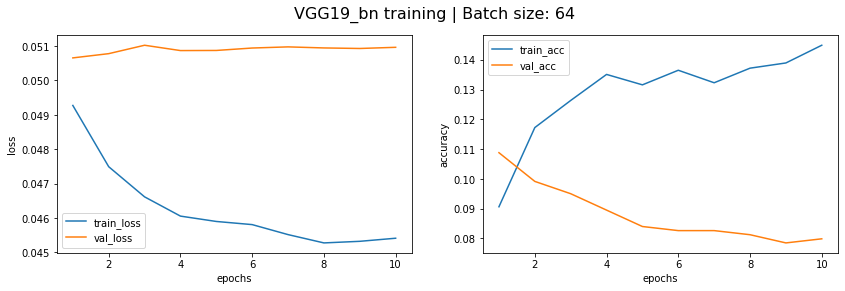


Training results:
	Min val loss 0.0507 was achieved during epoch #1
	Val accuracy during min val loss is 0.1088


In [13]:
model_vgg19_bn = models.vgg19_bn(pretrained=True)
for param in model_vgg19_bn.parameters():
    param.requires_grad = False
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=28)
model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## Predictions of VGG19 model and savind the results in CSV file

In [14]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

model_vgg19_bn.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        # print(f_names)
        samples = samples.to(DEVICE)
        outputs = model_vgg19_bn(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)
# print(all_files)

all_filenames = [f_name for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('/content/drive/MyDrive/vgg_test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


,File,Prediction
0,tensor(0),20
1,tensor(0),20
2,tensor(0),27
3,tensor(0),20
4,tensor(0),27
5,tensor(0),20
6,tensor(0),20
7,tensor(0),27
8,tensor(0),27
9,tensor(0),27


## Ensemble Model

In [15]:
class EnsembleModel(nn.Module):   
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(28 * 3, 28)
        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out
    
ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True    

ensemble_model = ensemble_model.to(DEVICE)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch: 1 | Learning rate: [0.0003]
2857
726


  5%|▌         | 1/20 [01:40<31:56, 100.86s/it]

	| New lowest val loss for Ensemble: 0.05233529809421088
Epoch: 2 | Learning rate: [0.0003]
2857
726


 10%|█         | 2/20 [03:14<28:55, 96.43s/it] 

	| New lowest val loss for Ensemble: 0.050856536413355635
Epoch: 3 | Learning rate: [0.0003]
2857
726


 15%|█▌        | 3/20 [04:47<26:52, 94.86s/it]

	| New lowest val loss for Ensemble: 0.05058938346946863
Epoch: 4 | Learning rate: [3.267e-05]
2857
726


 20%|██        | 4/20 [06:20<25:05, 94.08s/it]

	| New lowest val loss for Ensemble: 0.050580109774902175
Epoch: 5 | Learning rate: [9.9e-05]
2857
726


 25%|██▌       | 5/20 [07:52<23:24, 93.63s/it]

	| New lowest val loss for Ensemble: 0.05054522841429907
Epoch: 6 | Learning rate: [9.9e-05]
2857
726


 30%|███       | 6/20 [09:25<21:47, 93.40s/it]

	| New lowest val loss for Ensemble: 0.05053558231385286
Epoch: 7 | Learning rate: [1.0781099999999999e-05]
2857
726


 35%|███▌      | 7/20 [10:59<20:14, 93.41s/it]

	| New lowest val loss for Ensemble: 0.05052304070843153
Epoch: 8 | Learning rate: [3.267e-05]
2857


 40%|████      | 8/20 [12:28<18:25, 92.11s/it]

726
Epoch: 9 | Learning rate: [3.267e-05]
2857


 45%|████▌     | 9/20 [13:57<16:42, 91.10s/it]

726
Epoch: 10 | Learning rate: [3.557763e-06]
2857


 50%|█████     | 10/20 [15:27<15:06, 90.65s/it]

726
Epoch: 11 | Learning rate: [1.0781099999999999e-05]
2857
726


 55%|█████▌    | 11/20 [17:00<13:44, 91.57s/it]

	| New lowest val loss for Ensemble: 0.05050113739717762
Epoch: 12 | Learning rate: [1.0781099999999999e-05]
2857


 60%|██████    | 12/20 [18:30<12:08, 91.09s/it]

726
Epoch: 13 | Learning rate: [1.17406179e-06]
2857


 65%|██████▌   | 13/20 [20:00<10:34, 90.58s/it]

726
Epoch: 14 | Learning rate: [3.557763e-06]
2857


 70%|███████   | 14/20 [21:29<09:00, 90.06s/it]

726
Epoch: 15 | Learning rate: [3.557763e-06]
2857


 75%|███████▌  | 15/20 [22:57<07:28, 89.66s/it]

726
Epoch: 16 | Learning rate: [3.874403907e-07]
2857


 80%|████████  | 16/20 [24:26<05:57, 89.39s/it]

726
Epoch: 17 | Learning rate: [1.17406179e-06]
2857


 85%|████████▌ | 17/20 [25:55<04:27, 89.20s/it]

726
Epoch: 18 | Learning rate: [1.17406179e-06]
2857


 90%|█████████ | 18/20 [27:23<02:57, 88.95s/it]

726
Epoch: 19 | Learning rate: [1.27855328931e-07]
2857


 95%|█████████▌| 19/20 [28:52<01:28, 88.86s/it]

726
Epoch: 20 | Learning rate: [3.874403907e-07]
2857


100%|██████████| 20/20 [30:21<00:00, 91.06s/it]

726


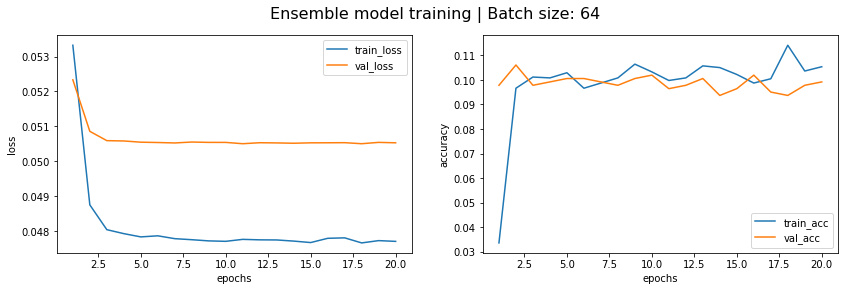


Training results:
	Min val loss 0.0505 was achieved during iteration #11
	Val accuracy during min val loss is 0.0964


In [16]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=20,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           num_epochs=20,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

## Predictions of Ensemble model and savind the results in CSV file

In [17]:
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        # print(f_names)
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)
# print(all_files)

all_filenames = [f_name for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False) 
submission_ensemble_df.head(10)

100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


,File,Prediction
0,tensor(0),21
1,tensor(0),20
2,tensor(0),4
3,tensor(0),4
4,tensor(0),8
5,tensor(0),8
6,tensor(0),4
7,tensor(0),27
8,tensor(0),8
9,tensor(0),4


## Loading trained models -- GPU

In [ ]:
# In case we want to use saved weights 

model_vgg19_bn = models.vgg19_bn(pretrained = False)
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=28)

model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=28)

model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=28)

model_vgg19_bn.load_state_dict(torch.load('/content/drive/MyDrive/VGG19_bn_weights.pth'))
model_resnet152.load_state_dict(torch.load('/content/drive/MyDrive/ResNet152_weights.pth'))
model_densenet161.load_state_dict(torch.load('/content/drive/MyDrive/DenseNet161_weights.pth'))

## Loading trained models -- CPU

In [ ]:
# In case we want to use saved weights 

model_vgg19_bn = models.vgg19_bn(pretrained = False)
model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=28)

model_resnet152 = models.resnet152(pretrained = False)
model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=28)

model_densenet161 = models.densenet161(pretrained = False)
model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=28)

model_vgg19_bn.load_state_dict(torch.load('/content/drive/MyDrive/VGG19_bn_weights.pth',map_location=torch.device('cpu')))
model_resnet152.load_state_dict(torch.load('/content/drive/MyDrive/ResNet152_weights.pth',map_location=torch.device('cpu')))
model_densenet161.load_state_dict(torch.load('/content/drive/MyDrive/DenseNet161_weights.pth',map_location=torch.device('cpu')))